## IMPORT DATASET AND MODEL

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/progetto lab AI/tesi/unet')

Mounted at /content/drive


In [2]:
%matplotlib inline
from LEVIR_Loader import get
from unet import unet

train_loader, val_loader, test_loader = get("drive/MyDrive/progetto lab AI/LEVIR-CD+", 1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 637 samples in drive/MyDrive/progetto lab AI/LEVIR-CD+/train
Found 129 samples in drive/MyDrive/progetto lab AI/LEVIR-CD+/val
Found 219 samples in drive/MyDrive/progetto lab AI/LEVIR-CD+/test


## PLOT SOME SAMPLES

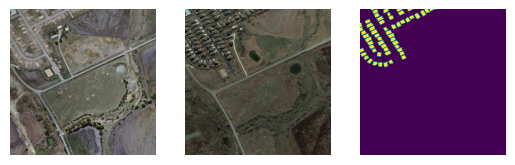

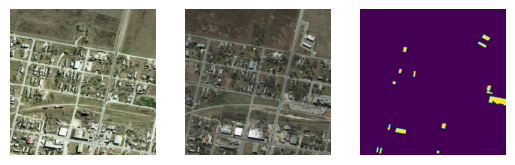

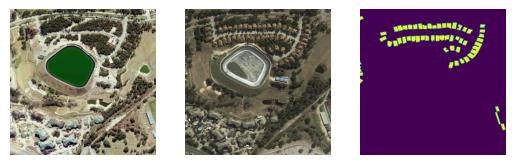

In [5]:
import matplotlib.pyplot as plt

def plot(max_plot):
    k = 1
    for batch_id, (images_A, images_B, images_label) in enumerate(train_loader):
        # image shapes: (1, C, H, W)
        for i in range(images_A.shape[0]):
            if i + images_A.shape[0]*batch_id + 1 > max_plot:
                return
            #print("Batch", batch_id)
            image_A = images_A[i]  # Remove the batch dimension if not needed (1, C, H, W) to (C, H, W)
            image_B = images_B[i]
            image_label = images_label[i]

            plt.subplot(1, 3, 1)  # Create subplots for each image
            plt.imshow(image_A.numpy().transpose((1, 2, 0)))  # transpose is needed to go from (C, H, W) to (H, W, C)
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(image_B.numpy().transpose((1, 2, 0)))
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(image_label.numpy().transpose((1, 2, 0)))
            plt.axis('off')
            plt.show()
            k += 1
plot(3)

## LOAD:

In [ ]:
from torch.optim import Adam
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATH = "drive/MyDrive/progetto lab AI/tesi/unet/saves/save_best_f1.pt"

net = unet()
net.to(device)
opt = Adam(net.parameters(), lr=0.001)

checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print("Loaded checkpoint at epoch:", epoch, ", loss:", loss)

Loaded checkpoint at epoch: 27 , loss: 0.03680931776762009


## CREATE NEW INSTANCE

In [ ]:
from torch.optim import Adam
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = unet()
net.to(device)
opt = Adam(net.parameters(), lr=0.001)
epoch = 0

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 18.0 MB/s eta 0:00:00


## TRAIN:

In [ ]:
import time
import torch
from torch.nn import BCELoss
from torch.optim import Adam

from torchmetrics.classification import BinaryF1Score

from tqdm import tqdm

best_val_loss = 99999
best_val_f1 = 0

lossFunc = BCELoss()
trainSteps = 50 # train epochs to perform

metric = BinaryF1Score()
metric.to(device)

startTime = time.time()
for e in range(trainSteps): # loop over epochs
	net.train()
	totalTrainLoss = 0
	totalValLoss = 0
	totalTrain_f1 = 0
	totalVal_f1 = 0
	print("Training...")
	# train loop
	for (x, x2, y) in tqdm(train_loader):
		(x, x2, y) = (x.to(device), x2.to(device), y.to(device))

		pred = net(torch.cat([x, x2], dim=1))

		loss = lossFunc(pred, y)

		opt.zero_grad()
		loss.backward()
		opt.step()

		totalTrainLoss += loss

		disc = pred > 0.5
		totalTrain_f1 += metric(disc, y)
	print("Validating...")

	with torch.no_grad(): # switch off autograd
		net.eval()
		# validation loop
		for (x, x2, y) in tqdm(val_loader):
			(x, x2, y) = (x.to(device), x2.to(device), y.to(device))

			pred = net(torch.cat([x, x2], dim=1))

			loss = lossFunc(pred, y)
			totalValLoss += loss

			disc = pred > 0.5
			totalVal_f1 += metric(disc, y)

	# average training and validation loss
	avgTrainLoss = totalTrainLoss / len(train_loader)
	avgValLoss = totalValLoss / len(val_loader)

	# average training and validation f1
	avgTrain_f1 = totalTrain_f1 / len(train_loader)
	avgVal_f1 = totalVal_f1 / len(val_loader)

	# save training checkpoint and losses arrays
	save(epoch+e+1, avgTrainLoss.item(), avgValLoss.item(), avgTrain_f1.item(), avgVal_f1.item())

	if avgVal_f1.item() > best_val_f1:
		saveBest_f1(epoch+e+1, avgTrainLoss.item())
		best_val_f1 = avgVal_f1.item()
	if avgValLoss.item() < best_val_loss:
		saveBest_loss(epoch+e+1, avgTrainLoss.item())
		best_val_loss = avgValLoss.item()

	print("EPOCH: {}/{}".format(epoch + e + 1, epoch + trainSteps))
	print("Train loss: {:.6f}, Test loss: {:.6f}".format(avgTrainLoss, avgValLoss))

# total training time
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.79it/s]


train losses save not found, new one created
validation losses save not found, new one created
train f1 save not found, new one created
validation f1 save not found, new one created
saved succesfully at epoch 1 with loss 0.1833270639181137 and f1 0.011951394379138947
EPOCH: 1/50
Train loss: 0.183327, Test loss: 0.254611
Training...


100%|██████████| 637/637 [02:16<00:00,  4.67it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.77it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 2 with loss 0.13710379600524902 and f1 0.03428000211715698
EPOCH: 2/50
Train loss: 0.137104, Test loss: 0.148386
Training...


100%|██████████| 637/637 [02:18<00:00,  4.60it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.73it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 3 with loss 0.12087754160165787 and f1 0.25054579973220825
EPOCH: 3/50
Train loss: 0.120878, Test loss: 0.122860
Training...


100%|██████████| 637/637 [02:19<00:00,  4.58it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.72it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 4 with loss 0.10488566011190414 and f1 0.34989914298057556
EPOCH: 4/50
Train loss: 0.104886, Test loss: 0.121304
Training...


100%|██████████| 637/637 [02:17<00:00,  4.63it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.66it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 5 with loss 0.09345211088657379 and f1 0.3951092064380646
EPOCH: 5/50
Train loss: 0.093452, Test loss: 0.149107
Training...


100%|██████████| 637/637 [02:17<00:00,  4.63it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.72it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 6 with loss 0.08450283855199814 and f1 0.4291797876358032
EPOCH: 6/50
Train loss: 0.084503, Test loss: 0.098893
Training...


100%|██████████| 637/637 [02:16<00:00,  4.67it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.67it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 7 with loss 0.07449129968881607 and f1 0.46001026034355164
EPOCH: 7/50
Train loss: 0.074491, Test loss: 0.108079
Training...


100%|██████████| 637/637 [02:16<00:00,  4.68it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.76it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 8 with loss 0.06897060573101044 and f1 0.4886036515235901
EPOCH: 8/50
Train loss: 0.068971, Test loss: 0.108432
Training...


100%|██████████| 637/637 [02:16<00:00,  4.65it/s]


Validating...


100%|██████████| 129/129 [00:18<00:00,  6.83it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 9 with loss 0.06389015167951584 and f1 0.5086378455162048
EPOCH: 9/50
Train loss: 0.063890, Test loss: 0.086022
Training...


100%|██████████| 637/637 [02:16<00:00,  4.67it/s]


Validating...


100%|██████████| 129/129 [00:18<00:00,  6.79it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 10 with loss 0.06152339652180672 and f1 0.5170774459838867
EPOCH: 10/50
Train loss: 0.061523, Test loss: 0.151404
Training...


100%|██████████| 637/637 [02:16<00:00,  4.67it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.71it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 11 with loss 0.05897192284464836 and f1 0.5303971767425537
EPOCH: 11/50
Train loss: 0.058972, Test loss: 0.086242
Training...


100%|██████████| 637/637 [02:18<00:00,  4.61it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.69it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 12 with loss 0.05928558483719826 and f1 0.5222521424293518
EPOCH: 12/50
Train loss: 0.059286, Test loss: 0.087759
Training...


100%|██████████| 637/637 [02:15<00:00,  4.68it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.76it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 13 with loss 0.0591648668050766 and f1 0.5392719507217407
EPOCH: 13/50
Train loss: 0.059165, Test loss: 0.114874
Training...


100%|██████████| 637/637 [02:15<00:00,  4.69it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.74it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 14 with loss 0.05376837030053139 and f1 0.5500966310501099
EPOCH: 14/50
Train loss: 0.053768, Test loss: 0.142967
Training...


100%|██████████| 637/637 [02:17<00:00,  4.64it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.71it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 15 with loss 0.05198655277490616 and f1 0.5597242116928101
EPOCH: 15/50
Train loss: 0.051987, Test loss: 0.090420
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.69it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 16 with loss 0.05169268324971199 and f1 0.5586920380592346
EPOCH: 16/50
Train loss: 0.051693, Test loss: 0.099354
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.72it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 17 with loss 0.051319241523742676 and f1 0.5615471005439758
EPOCH: 17/50
Train loss: 0.051319, Test loss: 0.147561
Training...


100%|██████████| 637/637 [02:16<00:00,  4.67it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.75it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 18 with loss 0.0471494235098362 and f1 0.5802860260009766
EPOCH: 18/50
Train loss: 0.047149, Test loss: 0.120011
Training...


100%|██████████| 637/637 [02:16<00:00,  4.68it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.78it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 19 with loss 0.04296540096402168 and f1 0.5976448655128479
EPOCH: 19/50
Train loss: 0.042965, Test loss: 0.090346
Training...


100%|██████████| 637/637 [02:16<00:00,  4.67it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.67it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 20 with loss 0.050715215504169464 and f1 0.5772870182991028
EPOCH: 20/50
Train loss: 0.050715, Test loss: 0.084915
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.76it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 21 with loss 0.04227417707443237 and f1 0.616405725479126
EPOCH: 21/50
Train loss: 0.042274, Test loss: 0.093967
Training...


100%|██████████| 637/637 [02:15<00:00,  4.70it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.74it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 22 with loss 0.04403131827712059 and f1 0.6001249551773071
EPOCH: 22/50
Train loss: 0.044031, Test loss: 0.102476
Training...


100%|██████████| 637/637 [02:15<00:00,  4.69it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.76it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 23 with loss 0.04064430296421051 and f1 0.6156975030899048
EPOCH: 23/50
Train loss: 0.040644, Test loss: 0.099976
Training...


100%|██████████| 637/637 [02:15<00:00,  4.69it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.75it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 24 with loss 0.04268593713641167 and f1 0.5975853204727173
EPOCH: 24/50
Train loss: 0.042686, Test loss: 0.101068
Training...


100%|██████████| 637/637 [02:16<00:00,  4.67it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.77it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 25 with loss 0.03990550711750984 and f1 0.6221258640289307
EPOCH: 25/50
Train loss: 0.039906, Test loss: 0.094316
Training...


100%|██████████| 637/637 [02:15<00:00,  4.68it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.78it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 26 with loss 0.03762203827500343 and f1 0.6239277124404907
EPOCH: 26/50
Train loss: 0.037622, Test loss: 0.123618
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.69it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 27 with loss 0.03680931776762009 and f1 0.6330294013023376
EPOCH: 27/50
Train loss: 0.036809, Test loss: 0.080872
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.74it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 28 with loss 0.04369393736124039 and f1 0.6028580069541931
EPOCH: 28/50
Train loss: 0.043694, Test loss: 0.081164
Training...


100%|██████████| 637/637 [02:17<00:00,  4.63it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.67it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 29 with loss 0.036947961896657944 and f1 0.6392790079116821
EPOCH: 29/50
Train loss: 0.036948, Test loss: 0.079931
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.72it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 30 with loss 0.034907881170511246 and f1 0.6386301517486572
EPOCH: 30/50
Train loss: 0.034908, Test loss: 0.122592
Training...


100%|██████████| 637/637 [02:16<00:00,  4.68it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.71it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 31 with loss 0.03639841824769974 and f1 0.6325300931930542
EPOCH: 31/50
Train loss: 0.036398, Test loss: 0.094228
Training...


100%|██████████| 637/637 [02:16<00:00,  4.67it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.73it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 32 with loss 0.03660031408071518 and f1 0.6349880695343018
EPOCH: 32/50
Train loss: 0.036600, Test loss: 0.074242
Training...


100%|██████████| 637/637 [02:17<00:00,  4.62it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.72it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 33 with loss 0.033040694892406464 and f1 0.6543143391609192
EPOCH: 33/50
Train loss: 0.033041, Test loss: 0.101531
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.66it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 34 with loss 0.03524595499038696 and f1 0.6471148729324341
EPOCH: 34/50
Train loss: 0.035246, Test loss: 0.091842
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:18<00:00,  6.84it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 35 with loss 0.0326143316924572 and f1 0.64756178855896
EPOCH: 35/50
Train loss: 0.032614, Test loss: 0.089131
Training...


100%|██████████| 637/637 [02:16<00:00,  4.67it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.69it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 36 with loss 0.03625042736530304 and f1 0.6429804563522339
EPOCH: 36/50
Train loss: 0.036250, Test loss: 0.086014
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.70it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 37 with loss 0.03250093758106232 and f1 0.6560491323471069
EPOCH: 37/50
Train loss: 0.032501, Test loss: 0.077216
Training...


100%|██████████| 637/637 [02:17<00:00,  4.64it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.76it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 38 with loss 0.032234929502010345 and f1 0.6561903357505798
EPOCH: 38/50
Train loss: 0.032235, Test loss: 0.083427
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.78it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 39 with loss 0.03374794125556946 and f1 0.6543749570846558
EPOCH: 39/50
Train loss: 0.033748, Test loss: 0.165065
Training...


100%|██████████| 637/637 [02:16<00:00,  4.68it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.76it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 40 with loss 0.037359800189733505 and f1 0.6281614899635315
EPOCH: 40/50
Train loss: 0.037360, Test loss: 0.097380
Training...


100%|██████████| 637/637 [02:16<00:00,  4.68it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.66it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 41 with loss 0.030375123023986816 and f1 0.6711752414703369
EPOCH: 41/50
Train loss: 0.030375, Test loss: 0.092993
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.68it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 42 with loss 0.030260344967246056 and f1 0.6697864532470703
EPOCH: 42/50
Train loss: 0.030260, Test loss: 0.084929
Training...


100%|██████████| 637/637 [02:16<00:00,  4.67it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.75it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 43 with loss 0.03173845261335373 and f1 0.6611602306365967
EPOCH: 43/50
Train loss: 0.031738, Test loss: 0.092097
Training...


100%|██████████| 637/637 [02:16<00:00,  4.65it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.73it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 44 with loss 0.028594324365258217 and f1 0.6815668940544128
EPOCH: 44/50
Train loss: 0.028594, Test loss: 0.093758
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.69it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 45 with loss 0.029078872874379158 and f1 0.6724342107772827
EPOCH: 45/50
Train loss: 0.029079, Test loss: 0.114752
Training...


100%|██████████| 637/637 [02:16<00:00,  4.65it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.70it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 46 with loss 0.029254622757434845 and f1 0.6749332547187805
EPOCH: 46/50
Train loss: 0.029255, Test loss: 0.076146
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.72it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 47 with loss 0.032032206654548645 and f1 0.6614460349082947
EPOCH: 47/50
Train loss: 0.032032, Test loss: 0.089085
Training...


100%|██████████| 637/637 [02:16<00:00,  4.67it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.67it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 48 with loss 0.028058180585503578 and f1 0.686028778553009
EPOCH: 48/50
Train loss: 0.028058, Test loss: 0.097195
Training...


100%|██████████| 637/637 [02:16<00:00,  4.65it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.69it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 49 with loss 0.0276742335408926 and f1 0.6818037033081055
EPOCH: 49/50
Train loss: 0.027674, Test loss: 0.088787
Training...


100%|██████████| 637/637 [02:16<00:00,  4.66it/s]


Validating...


100%|██████████| 129/129 [00:19<00:00,  6.73it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 50 with loss 0.028669187799096107 and f1 0.6754185557365417
EPOCH: 50/50
Train loss: 0.028669, Test loss: 0.076366
Total time taken to train the model: 7872.52s


## SAVE:

In [ ]:
# Additional information
import numpy as np
def saveBest_f1(EPOCH, TRAIN_LOSS):
  SAVE_NAME = "save_best_f1"
  PATH = "drive/MyDrive/progetto lab AI/tesi/unet/saves/"

  torch.save({
              'epoch': EPOCH,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': opt.state_dict(),
              'loss': TRAIN_LOSS,
              }, PATH + SAVE_NAME + ".pt")

def saveBest_loss(EPOCH, TRAIN_LOSS):
  SAVE_NAME = "save_best_loss"
  PATH = "drive/MyDrive/progetto lab AI/tesi/unet/saves/"

  torch.save({
              'epoch': EPOCH,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': opt.state_dict(),
              'loss': TRAIN_LOSS,
              }, PATH + SAVE_NAME + ".pt")

def save(EPOCH, TRAIN_LOSS, VAL_LOSS, TRAIN_F1, VAL_F1):
  SAVE_NAME = "save"
  PATH = "drive/MyDrive/progetto lab AI/tesi/unet/saves/"

  torch.save({
              'epoch': EPOCH,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': opt.state_dict(),
              'loss': TRAIN_LOSS,
              }, PATH + SAVE_NAME + ".pt")

  ## save losses
  train_losses = None
  try:
    train_losses = np.fromfile(PATH + "train_losses_" + SAVE_NAME + ".arr", dtype=float)
    print("train losses file found")
  except:
    train_losses = np.array([])
    print("train losses save not found, new one created")
  train_losses = np.append(train_losses, TRAIN_LOSS)
  train_losses.tofile(PATH + "train_losses_" + SAVE_NAME + ".arr")

  val_losses = None
  try:
    val_losses = np.fromfile(PATH + "val_losses_" + SAVE_NAME + ".arr", dtype=float)
    print("train losses file found")
  except:
    val_losses = np.array([])
    print("validation losses save not found, new one created")
  val_losses = np.append(val_losses, VAL_LOSS)
  val_losses.tofile(PATH + "val_losses_" + SAVE_NAME + ".arr")

  ## save f1 scores
  train_f1 = None
  try:
    train_f1 = np.fromfile(PATH + "train_f1_" + SAVE_NAME + ".arr", dtype=float)
    print("train f1 file found")
  except:
    train_f1 = np.array([])
    print("train f1 save not found, new one created")
  train_f1 = np.append(train_f1, TRAIN_F1)
  train_f1.tofile(PATH + "train_f1_" + SAVE_NAME + ".arr")

  val_f1 = None
  try:
    val_f1 = np.fromfile(PATH + "val_f1_" + SAVE_NAME + ".arr", dtype=float)
    print("validation f1 file found")
  except:
    val_f1 = np.array([])
    print("validation f1 save not found, new one created")
  val_f1 = np.append(val_f1, VAL_F1)
  val_f1.tofile(PATH + "val_f1_" + SAVE_NAME + ".arr")

  print("saved succesfully at epoch", EPOCH, "with loss", TRAIN_LOSS, "and f1", TRAIN_F1)

## TEST

In [ ]:
import matplotlib.pyplot as plt

for batch_id, (images_A, images_B, images_label) in enumerate(val_loader):
    # image shapes: (2, C, H, W)]

    out = net(torch.cat([images_A.cuda(), images_B.cuda()], dim=1))

    for i in range(images_A.shape[0]):
        image_A = images_A[i]  # Remove the batch dimension if not needed (1, C, H, W) to (C, H, W)
        image_B = images_B[i]
        image_label = images_label[i]

        before = plt.subplot(2, 3, 1)  # Create subplots for each image
        before.title.set_text("Before:")
        plt.imshow(image_A.numpy().transpose((1, 2, 0)))  # transpose is needed to go from (C, H, W) to (H, W, C)
        plt.axis('off')

        after = plt.subplot(2, 3, 2)
        after.title.set_text("After:")
        plt.imshow(image_B.numpy().transpose((1, 2, 0)))
        plt.axis('off')

        exp_fig = plt.subplot(2, 3, 3)
        exp_fig.title.set_text("Expected:")
        plt.imshow(image_label.numpy().transpose((1, 2, 0)))  # transpose is not needed because image_label is one channel only
        plt.axis('off')

        pred_nd = plt.subplot(2, 3, 4)
        pred_nd.title.set_text("Predicted (not discretized):")
        plt.imshow(out[i].cpu().detach().numpy().transpose((1, 2, 0)))  # transpose is needed to go from (C, H, W) to (H, W, C)
        plt.axis('off')


        discretize = True
        if discretize:
            e = out[i]
            pref_fig = plt.subplot(2, 3, 6)
            pref_fig.title.set_text("Predicted (discretized):")
            disc_img = (e>0.5).float().cpu().detach().numpy()
            #print(disc_img)
            plt.imshow(disc_img.transpose((1, 2, 0)))  # transpose is needed to go from (C, H, W) to (H, W, C)
            plt.axis('off')

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

## PLOT LOSSES

train losses file found
train losses file found
train f1 file found
val f1 file found


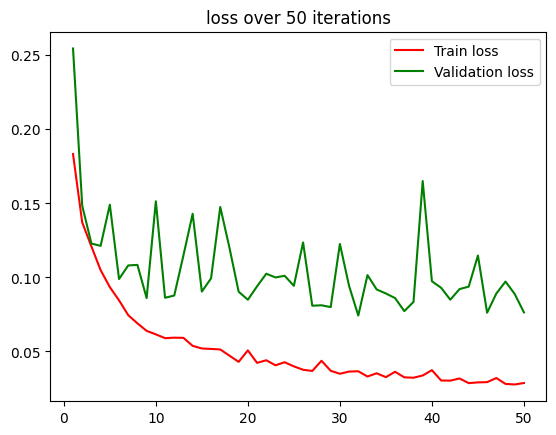

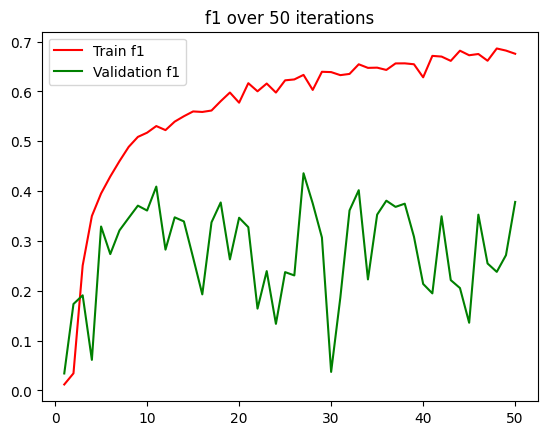

Best epoch for validation loss: 32
Best epoch for validation f1: 27


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

SAVE_NAME = "save"

PATH = "drive/MyDrive/progetto lab AI/tesi/unet/saves/"

train_losses = None
try:
  train_losses = np.fromfile(PATH + "train_losses_" + SAVE_NAME + ".arr", dtype=float)
  print("train losses file found")
except:
  train_losses = np.array([])
  print("train losses save not found, new one created")

val_losses = None
try:
  val_losses = np.fromfile(PATH + "val_losses_" + SAVE_NAME + ".arr", dtype=float)
  print("train losses file found")
except:
  val_losses = np.array([])
  print("validation losses save not found, new one created")


train_f1 = None
try:
  train_f1 = np.fromfile(PATH + "train_f1_" + SAVE_NAME + ".arr", dtype=float)
  print("train f1 file found")
except:
  train_f1 = np.array([])
  print("train f1 save not found, new one created")

val_f1 = None
try:
  val_f1 = np.fromfile(PATH + "val_f1_" + SAVE_NAME + ".arr", dtype=float)
  print("val f1 file found")
except:
  val_f1 = np.array([])
  print("val f1 save not found, new one created")


def plot(TRAIN_ARR, VAL_ARR, type):
  assert len(TRAIN_ARR) == len(VAL_ARR)
  x = [i+1 for i in range(len(TRAIN_ARR))]
  plt.title(type + " over " + str(len(TRAIN_ARR)) + " iterations")
  plt.plot(x, TRAIN_ARR, color="red", label="Train " + type)
  plt.plot(x, VAL_ARR, color="green", label="Validation " + type)
  plt.legend()

  plt.show()

plot(train_losses, val_losses, "loss")
plot(train_f1, val_f1, "f1")

best = None
best_epoch = 0
for i in range(len(val_losses)):
  if best is None or val_losses[i] < best:
    best = val_losses[i]
    best_epoch = i + 1
print("Best epoch for validation loss:", best_epoch)

best = None
for i in range(len(val_f1)):
  if best is None or val_f1[i] > best:
    best = val_f1[i]
    best_epoch = i + 1
print("Best epoch for validation f1:", best_epoch)